In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## **Exploratory Data Analysis (EDA)**
   - Objective: Perform an in-depth exploratory analysis to understand the distribution of ratings, most reviewed books, most active users, etc.
   - Business Value: Provides a comprehensive overview of the dataset, which can be used to identify potential areas of improvement or opportunities.
   - Approach: Use visualization tools like Matplotlib, Seaborn, or PowerBI to create insightful visualizations.

In [2]:
df_cleaned_rating = pd.read_csv("/kaggle/input/books-rating-cleaned/Books_rating_cleaned.csv")
df_cleaned_rating.head()

,Title,Price,review/score,Lemmatized review/summary,Lemmatized review/text
0,Its Only Art If Its Well Hung!,NaN,4.0,nice collection julie strain image,julie strain fans collection photo page worth ...
1,Dr. Seuss: American Icon,NaN,5.0,really enjoy,do not care much dr seuss reading philip nel b...
2,Dr. Seuss: American Icon,NaN,5.0,essential every personal public library,people become book read child father man dr se...
3,Dr. Seuss: American Icon,NaN,4.0,phlip nel give silly seuss serious treatment,theodore seuss geisel aka quotdr seussquot one...
4,Dr. Seuss: American Icon,NaN,4.0,good academic overview,philip nel dr seuss american iconthis basicall...


In [3]:
df_cleaned_rating.shape

(2990603, 5)

In [4]:
df_cleaned_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2990603 entries, 0 to 2990602
Data columns (total 5 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Title                      object 
 1   Price                      float64
 2   review/score               float64
 3   Lemmatized review/summary  object 
 4   Lemmatized review/text     object 
dtypes: float64(2), object(3)
memory usage: 114.1+ MB


In [5]:
df_cleaned_rating.isnull().sum()

Title                              0
Price                        2510275
review/score                       0
Lemmatized review/summary      18126
Lemmatized review/text          9396
dtype: int64

In [6]:
# Remove rows where the null value count is insignificant
df_cleaned_rating.dropna(subset=['Lemmatized review/summary', 'Lemmatized review/text'], inplace = True)

missing_values = df_cleaned_rating.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Title                              0
Price                        2495206
review/score                       0
Lemmatized review/summary          0
Lemmatized review/text             0
dtype: int64


In [7]:
df_cleaned_rating.shape

(2972448, 5)

In [4]:
pip install wordcloud matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

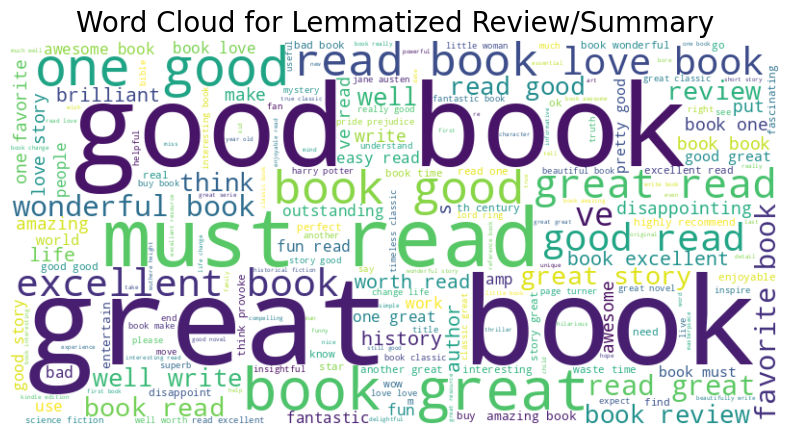

In [6]:
# Concatenate all text in the 'Lemmatized review/summary' column
summary_text = ' '.join(df_cleaned_rating['Lemmatized review/summary'].dropna().astype(str))

# Generate the word cloud from the text in the 'Lemmatized review/summary' column
generate_word_cloud(summary_text, 'Word Cloud for Lemmatized Review/Summary')

## **Data Analysis**

## 1. **Sentiment Analysis**
   - Objective: Determine the sentiment of the reviews (positive, neutral, negative).
   - Business Value: Helps in understanding customer satisfaction, identifying trends in customer feedback, and improving products based on feedback.
   - Approach: Use Natural Language Processing (NLP) techniques to classify the sentiment of reviews. Tools like VADER, TextBlob, or machine learning models like Naive Bayes or LSTM can be used for this purpose.
   
   Understanding customer sentiment can guide inventory decisions. For instance, stocking more books with overwhelmingly positive reviews or avoiding those with negative sentiment can improve sales. Sentiment analysis also helps in identifying books that are highly praised for specific qualities (e.g., strong character development) that could be highlighted in marketing campaigns.

provides insights into what specific aspects of books (e.g., plot, writing style, character development) readers appreciate or criticize. A bookshop could use this information to recommend books based on customer preferences or address common complaints in marketing materials. For example, if readers frequently praise the plot twists in a mystery novel, the shop can promote this feature to attract customers who enjoy such elements.

### VADER (Valence Aware Dictionary and sEntiment Reasoner) for sentiment analysis on Amazon book reviews:

In [4]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [26]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from joblib import Parallel, delayed

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define the sentiment analysis function
def analyze_sentiment_vader(text):
    if isinstance(text, str):  # Check if the value is a string
        sentiment_score = analyzer.polarity_scores(text)
        compound_score = sentiment_score['compound']

        # Define sentiment categories based on compound score
        if compound_score >= 0.5:
            sentiment_label = 'Better'
        elif compound_score >= 0.2:
            sentiment_label = 'Good'
        elif compound_score >= -0.2:
            sentiment_label = 'Neutral'
        elif compound_score >= -0.5:
            sentiment_label = 'Bad'
        else:
            sentiment_label = 'Worse'

        return compound_score, sentiment_label
    return None, None

# Load the DataFrame (assuming it's already loaded as df_cleaned_rating)
print("Starting sentiment analysis...")

# Ensure all values in the required columns are strings
df_cleaned_rating['Lemmatized review/text'] = df_cleaned_rating['Lemmatized review/text'].astype(str)
df_cleaned_rating['Lemmatized review/summary'] = df_cleaned_rating['Lemmatized review/summary'].astype(str)

# Define a function to process sentiment analysis and print progress
def process_sentiment_analysis(text, summary, index, total):
    combined_text = text + ' ' + summary  # Combine the review text and summary
    if index % (total // 10) == 0:  # Print progress every 10% of rows
        print(f"Processing row {index} of {total}...")
    return analyze_sentiment_vader(combined_text)

# Apply sentiment analysis in parallel with progress updates
num_cores = -1  # Use all available cores
total_rows = len(df_cleaned_rating)
results = Parallel(n_jobs=num_cores)(
    delayed(process_sentiment_analysis)(text, summary, idx, total_rows)
    for idx, (text, summary) in enumerate(zip(df_cleaned_rating['Lemmatized review/text'], df_cleaned_rating['Lemmatized review/summary']))
)

# Split results into two columns: Sentiment_Score and Sentiment_Category_VADER
df_cleaned_rating['Sentiment_Score'], df_cleaned_rating['Sentiment_Category_VADER'] = zip(*results)

print("Sentiment analysis completed.")

Starting sentiment analysis...
Sentiment analysis completed.


In [28]:
# Save the DataFrame with sentiment categories
df_cleaned_rating.to_csv('Books_reviews_with_sentiment.csv', index=False)

Processing row 297244 of 2972448...
Processing row 2080708 of 2972448...
Processing row 2972440 of 2972448...
Processing row 0 of 2972448...
Processing row 1486220 of 2972448...
Processing row 2377952 of 2972448...
Processing row 891732 of 2972448...
Processing row 1188976 of 2972448...
Processing row 1783464 of 2972448...
Processing row 2675196 of 2972448...
Processing row 594488 of 2972448...


In [30]:
# Count the number of occurrences for each sentiment category
sentiment_counts = df_cleaned_rating['Sentiment_Category_VADER'].value_counts()
sentiment_counts

Sentiment_Category_VADER
Better     2313817
Worse       256178
Good        172756
Neutral     141513
Bad          88184
Name: count, dtype: int64

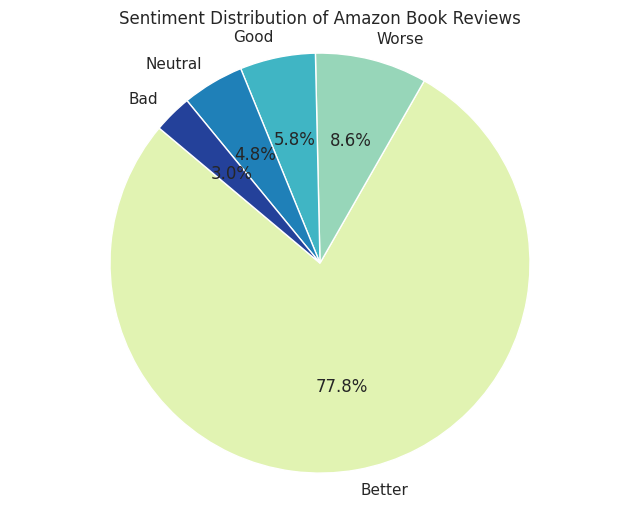

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plot using Seaborn
sns.set(style="whitegrid")

# Define the sentiment counts (assuming sentiment_counts is a Series with sentiment categories and their counts)
sentiment_counts = df_cleaned_rating['Sentiment_Category_VADER'].value_counts()

# Draw a pie chart
plt.figure(figsize=(8, 6))
colors = sns.color_palette("YlGnBu", n_colors=len(sentiment_counts))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', \
        startangle=140, colors=colors)
plt.title('Sentiment Distribution of Amazon Book Reviews')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Save the pie chart as an image file
plt.savefig('sentiment_distribution_pie_chart_viridis.png')

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

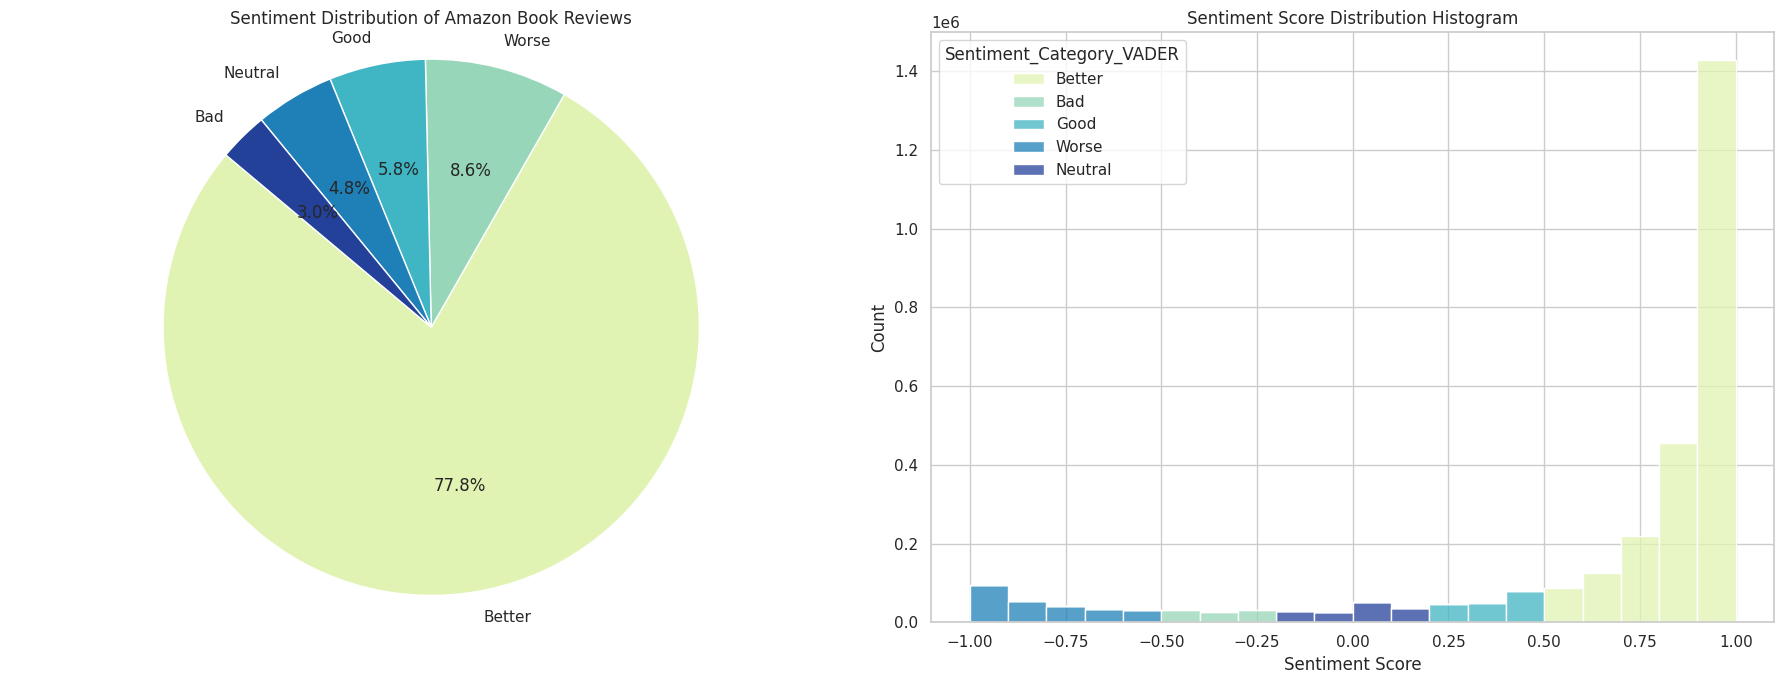

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plots using Seaborn
sns.set(style="whitegrid")

# Define the sentiment counts (assuming sentiment_counts is a Series with sentiment categories and their counts)
sentiment_counts = df_cleaned_rating['Sentiment_Category_VADER'].value_counts()

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Draw the pie chart
colors = sns.color_palette("YlGnBu", n_colors=len(sentiment_counts))
ax[0].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
ax[0].set_title('Sentiment Distribution of Amazon Book Reviews')
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Draw the histogram of sentiment scores
sns.histplot(data=df_cleaned_rating, x='Sentiment_Score', hue='Sentiment_Category_VADER', palette="YlGnBu", multiple='stack', ax=ax[1], bins=20)
ax[1].set_title('Sentiment Score Distribution Histogram')
ax[1].set_xlabel('Sentiment Score')
ax[1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Save the figure as an image file
plt.savefig('sentiment_distribution_pie_histogram.png')

plt.show()

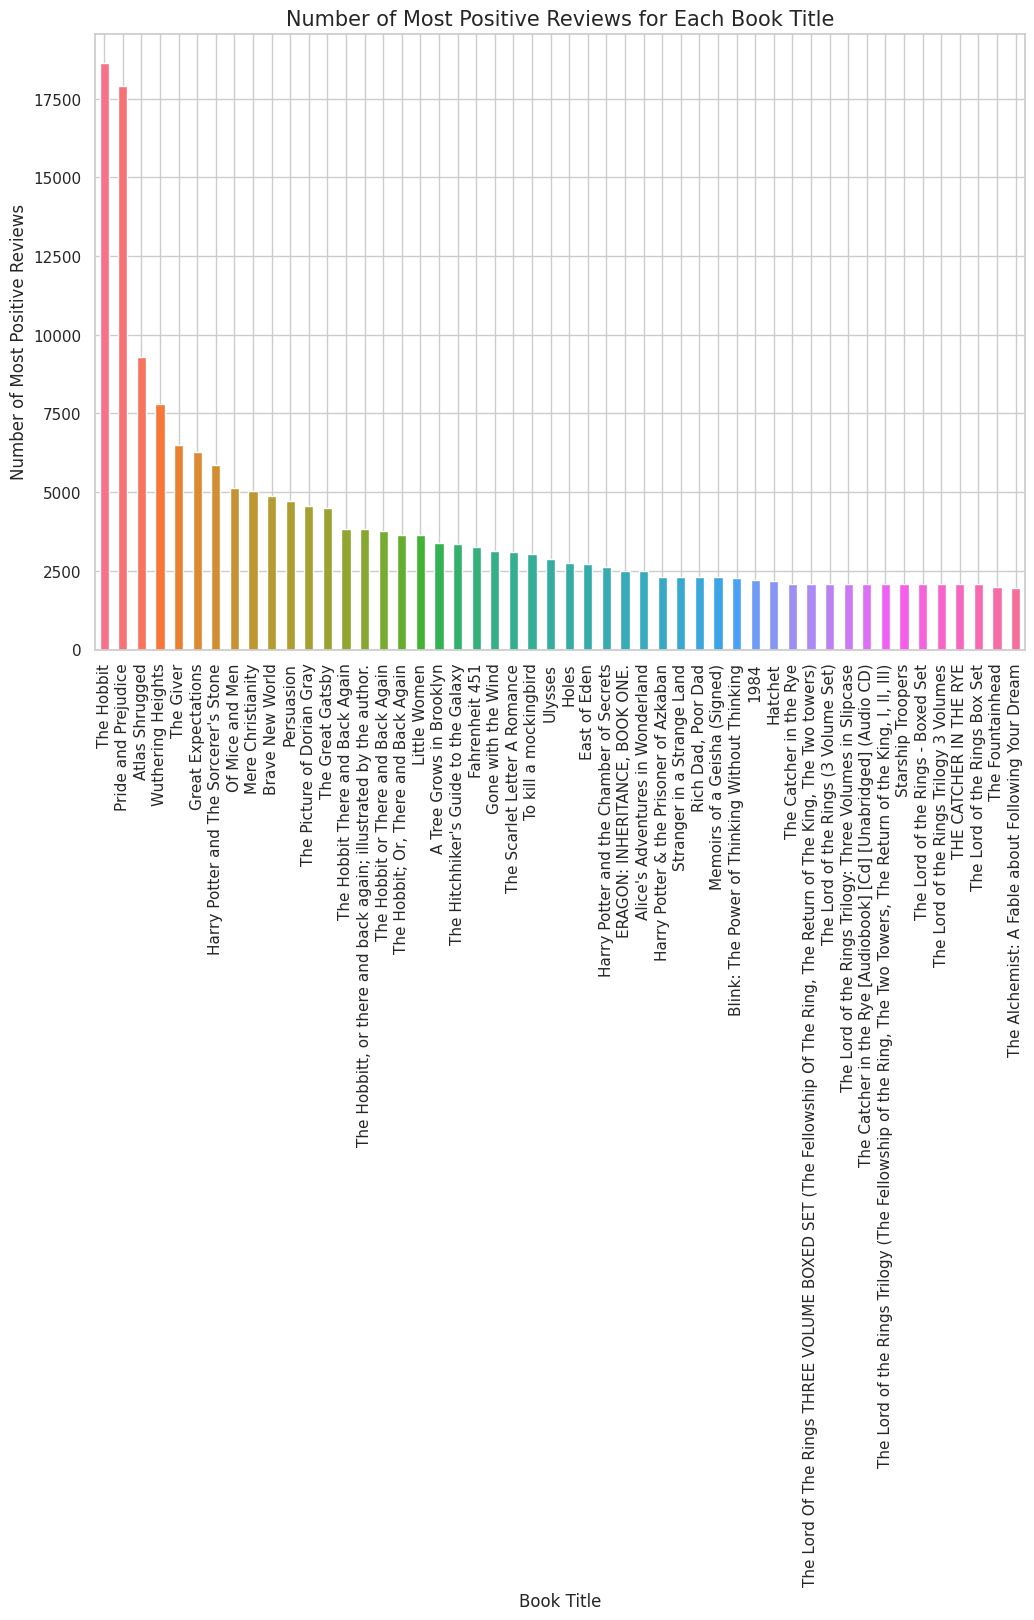

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'Sentiment_Category_VADER' column is properly set to 'Better' or other sentiment labels
positive_reviews = df_cleaned_rating[df_cleaned_rating['Sentiment_Category_VADER'] == 'Better']

# Count the number of positive reviews for each book title
review_counts = positive_reviews['Title'].value_counts()

# Set the style for the plot using Seaborn
sns.set(style="whitegrid")

# Plot the top 50 book titles with the most positive reviews
plt.figure(figsize=(12, 8))
# Define the color palette
colors = sns.color_palette("husl", n_colors=50)  

# Plotting with specified color palette
review_counts.head(50).plot(kind='bar', color=colors)
plt.title('Number of Most Positive Reviews for Each Book Title', fontsize=15)
plt.xlabel('Book Title')
plt.ylabel('Number of Most Positive Reviews')
plt.xticks(rotation=90)
plt.show()

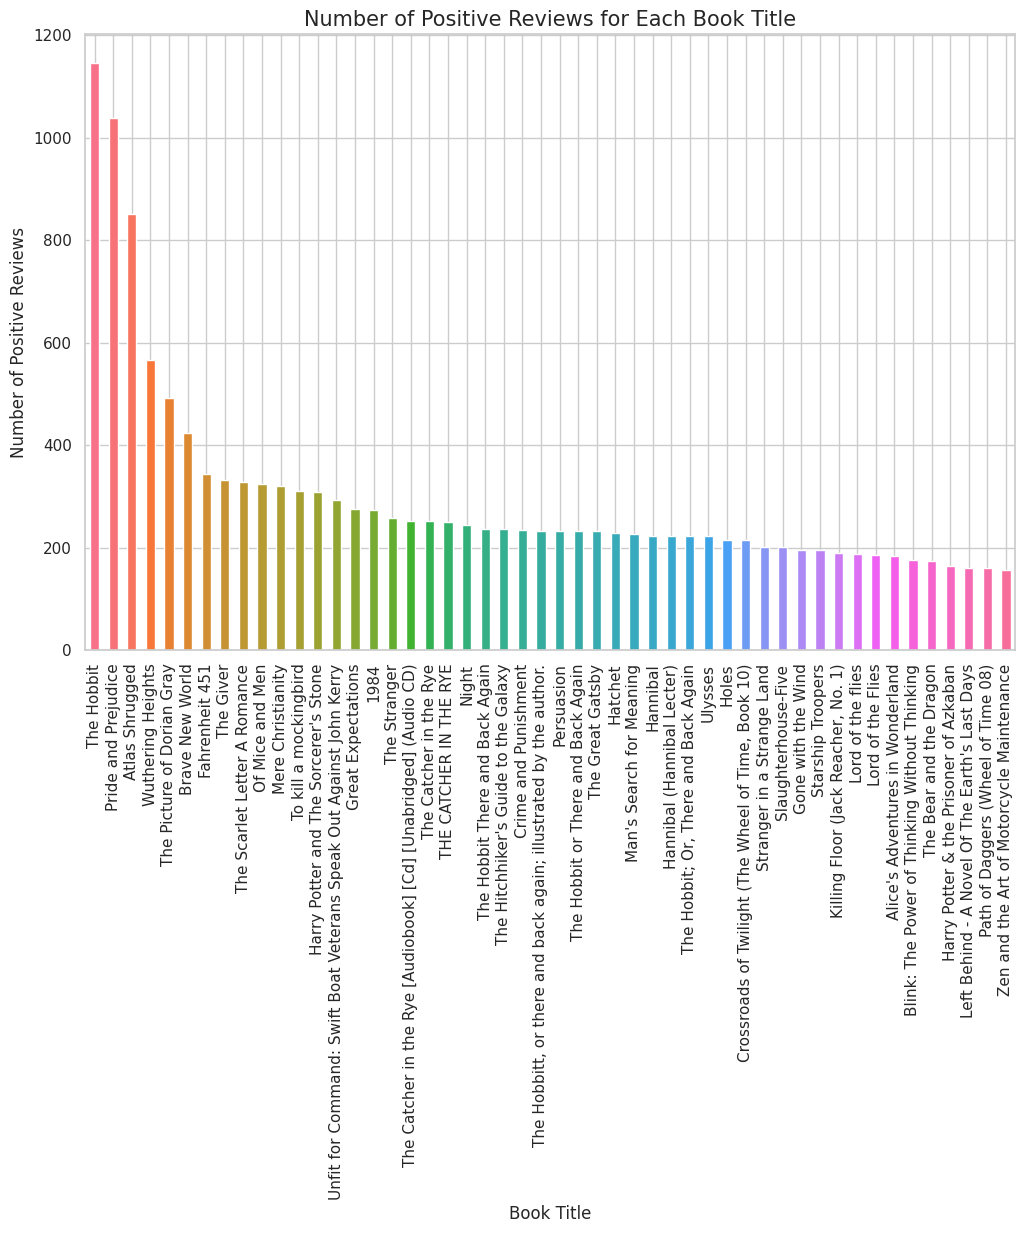

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'Sentiment_Category_VADER' column is properly set to 'Better' or other sentiment labels
positive_reviews = df_cleaned_rating[df_cleaned_rating['Sentiment_Category_VADER'] == 'Good']

# Count the number of positive reviews for each book title
review_counts = positive_reviews['Title'].value_counts()

# Set the style for the plot using Seaborn
sns.set(style="whitegrid")

# Plot the top 50 book titles with the most positive reviews
plt.figure(figsize=(12, 8))
# Define the color palette
colors = sns.color_palette("husl", n_colors=50) 

# Plotting with specified color palette
review_counts.head(50).plot(kind='bar', color=colors)
plt.title('Number of Positive Reviews for Each Book Title', fontsize=15)
plt.xlabel('Book Title')
plt.ylabel('Number of Positive Reviews')
plt.xticks(rotation=90)
plt.show()

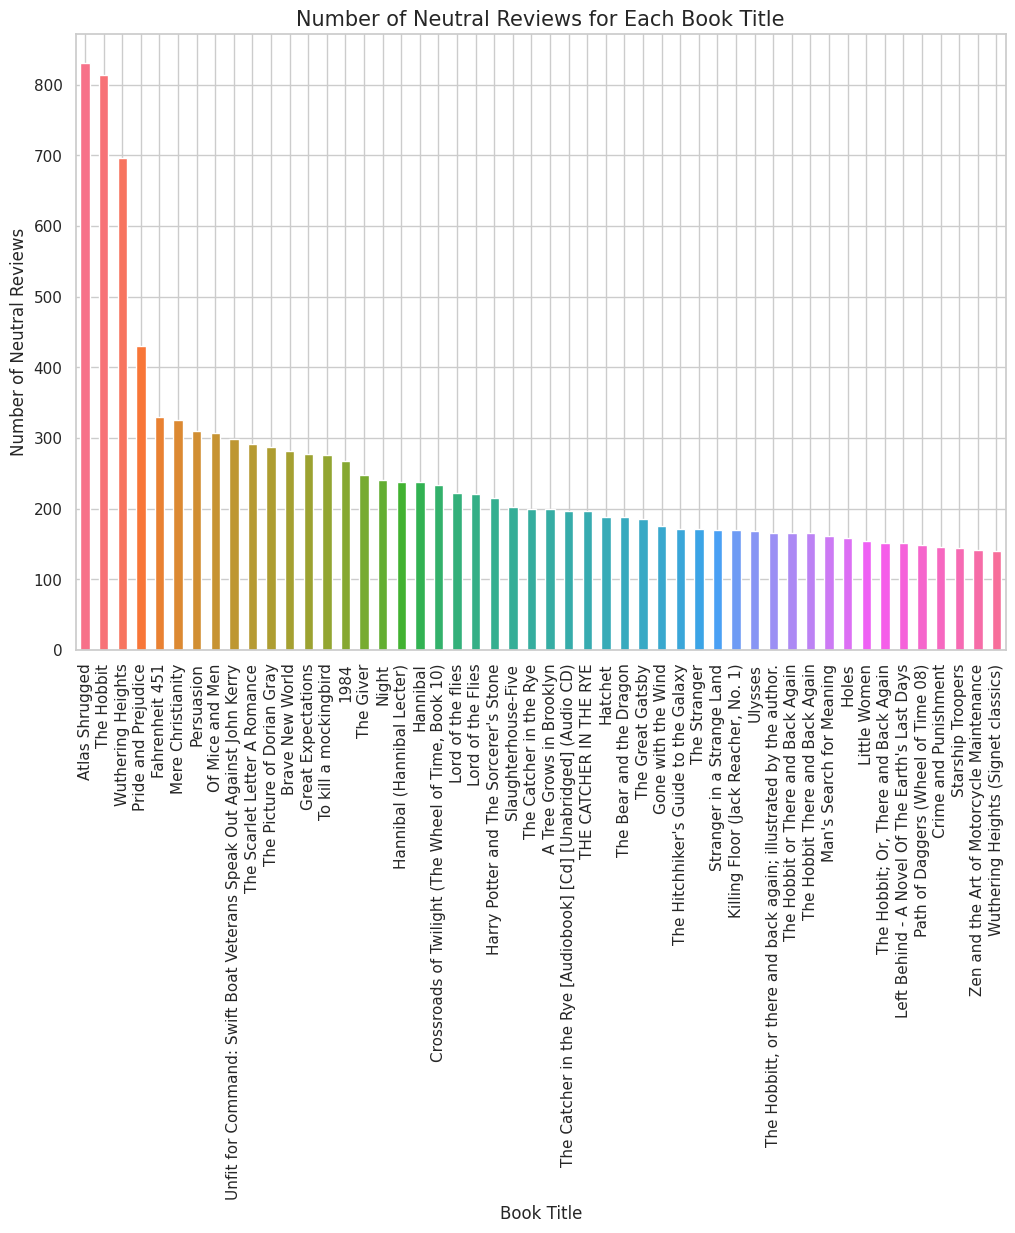

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'Sentiment_Category_VADER' column is properly set to 'Better' or other sentiment labels
positive_reviews = df_cleaned_rating[df_cleaned_rating['Sentiment_Category_VADER'] == 'Neutral']

# Count the number of positive reviews for each book title
review_counts = positive_reviews['Title'].value_counts()

# Set the style for the plot using Seaborn
sns.set(style="whitegrid")

# Plot the top 50 book titles with the most positive reviews
plt.figure(figsize=(12, 8))
# Define the color palette
colors = sns.color_palette("husl", n_colors=50) 

# Plotting with specified color palette
review_counts.head(50).plot(kind='bar', color=colors)
plt.title('Number of Neutral Reviews for Each Book Title', fontsize=15)
plt.xlabel('Book Title')
plt.ylabel('Number of Neutral Reviews')
plt.xticks(rotation=90)
plt.show()

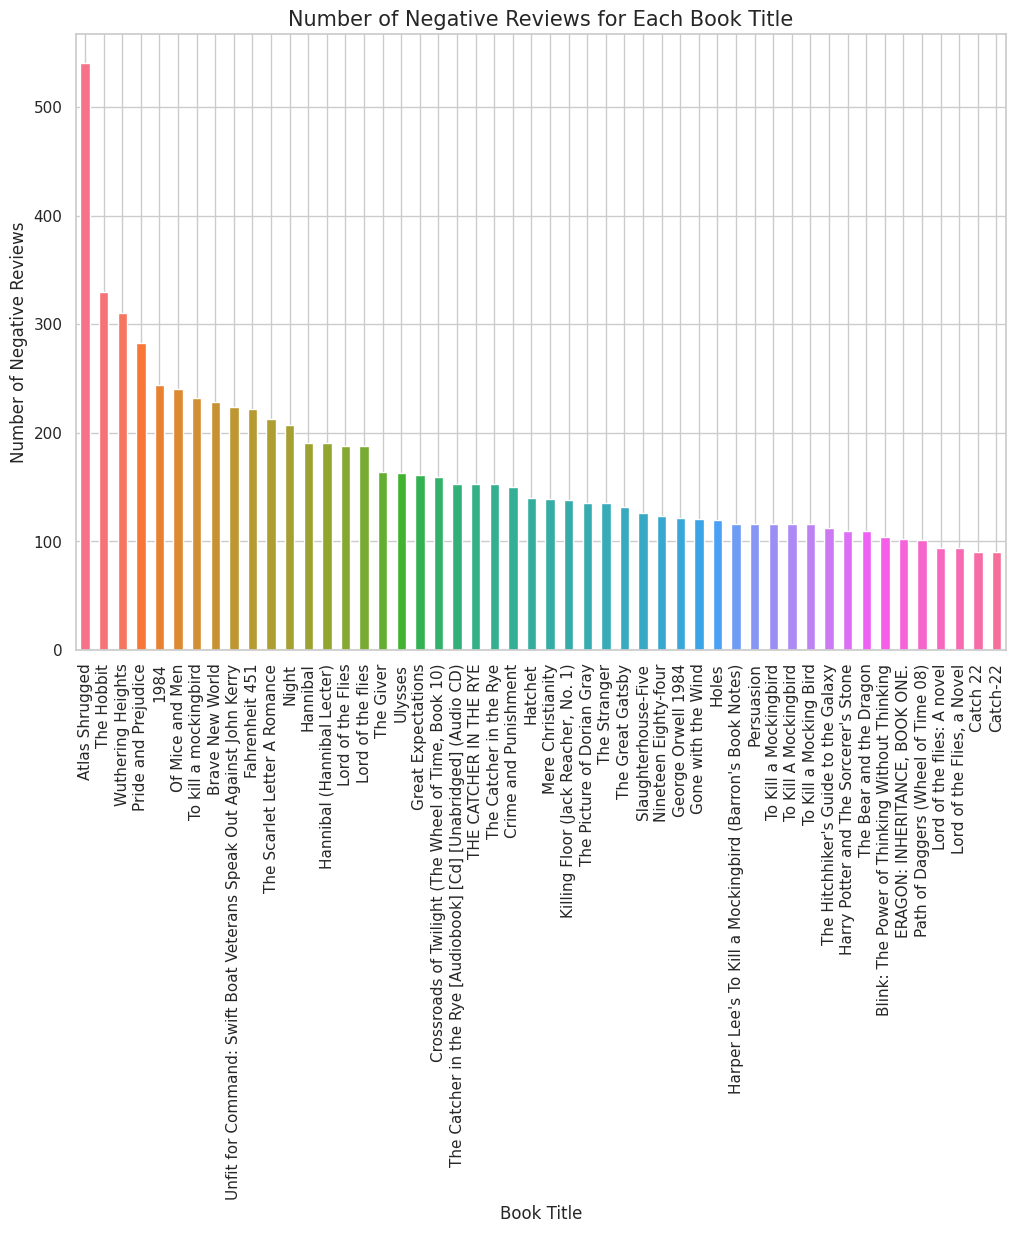

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'Sentiment_Category_VADER' column is properly set to 'Better' or other sentiment labels
positive_reviews = df_cleaned_rating[df_cleaned_rating['Sentiment_Category_VADER'] == 'Bad']

# Count the number of positive reviews for each book title
review_counts = positive_reviews['Title'].value_counts()

# Set the style for the plot using Seaborn
sns.set(style="whitegrid")

# Plot the top 50 book titles with the most positive reviews
plt.figure(figsize=(12, 8))
# Define the color palette
colors = sns.color_palette("husl", n_colors=50) 

# Plotting with specified color palette
review_counts.head(50).plot(kind='bar', color=colors)
plt.title('Number of Negative Reviews for Each Book Title', fontsize=15)
plt.xlabel('Book Title')
plt.ylabel('Number of Negative Reviews')
plt.xticks(rotation=90)
plt.show()

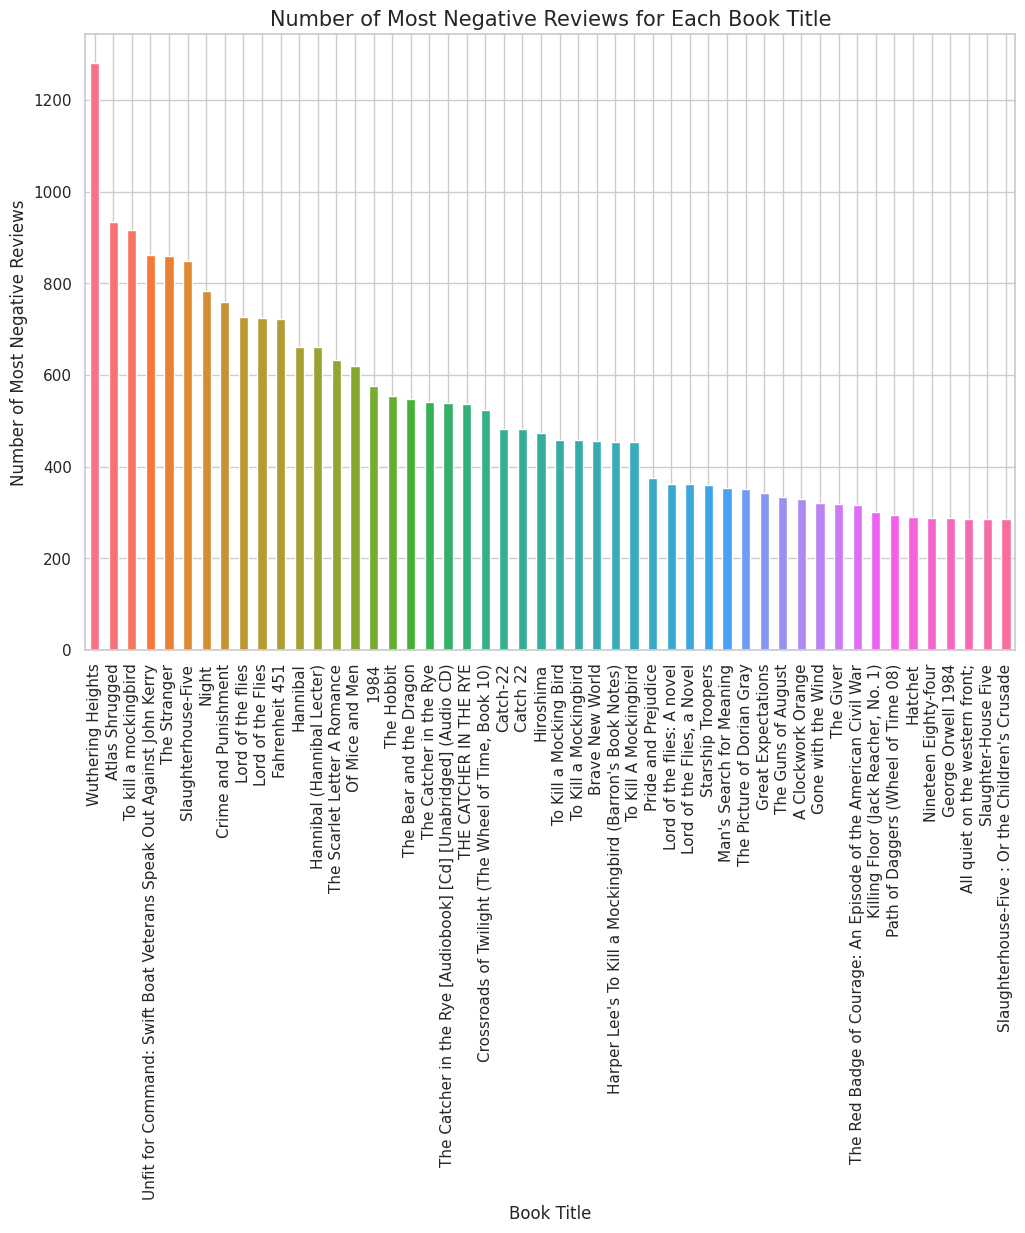

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'Sentiment_Category_VADER' column is properly set to 'Better' or other sentiment labels
positive_reviews = df_cleaned_rating[df_cleaned_rating['Sentiment_Category_VADER'] == 'Worse']

# Count the number of positive reviews for each book title
review_counts = positive_reviews['Title'].value_counts()

# Set the style for the plot using Seaborn
sns.set(style="whitegrid")

# Plot the top 50 book titles with the most positive reviews
plt.figure(figsize=(12, 8))
# Define the color palette
colors = sns.color_palette("husl", n_colors=50) 

# Plotting with specified color palette
review_counts.head(50).plot(kind='bar', color=colors)
plt.title('Number of Most Negative Reviews for Each Book Title', fontsize=15)
plt.xlabel('Book Title')
plt.ylabel('Number of Most Negative Reviews')
plt.xticks(rotation=90)
plt.show()

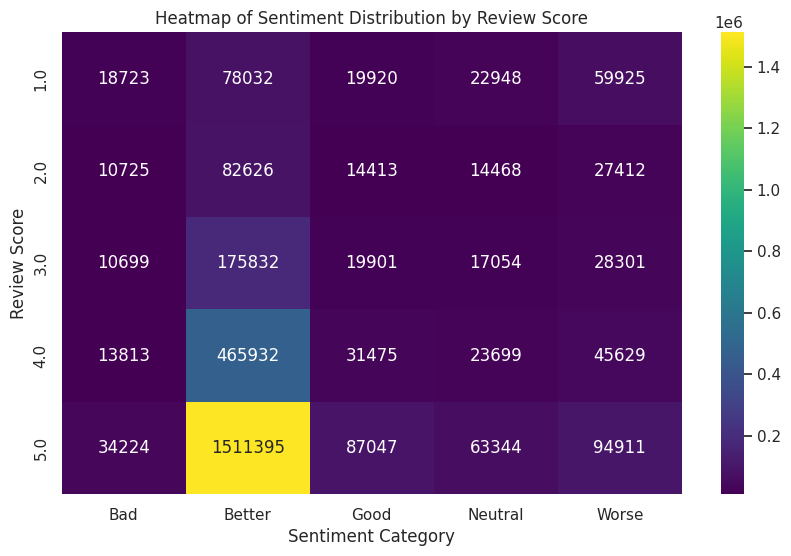

In [38]:
# Heatmap of sentiment distribution by Review Score

import matplotlib.pyplot as plt
import seaborn as sns

# Create a pivot table for the heatmap
pivot_table = df_cleaned_rating.pivot_table(index='review/score', columns='Sentiment_Category_VADER', aggfunc='size', fill_value=0)

# Draw a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='viridis')
plt.title('Heatmap of Sentiment Distribution by Review Score')
plt.xlabel('Sentiment Category')
plt.ylabel('Review Score')
plt.show()

Cell Values: Each cell in the heatmap shows the count of reviews for a particular combination of review score and sentiment category. For example, if a cell has the value 25, it means that there are 25 reviews for a specific review score that fall into a particular sentiment category.

Interpreting the Heatmap:

High Counts: If a cell is dark red, it means that there are many reviews for that review score and sentiment category combination.

Low Counts: If a cell is light blue, it means there are few reviews for that combination.

Patterns: You can observe patterns in how different sentiment categories are distributed across various review scores. For instance, you might see that high review scores are predominantly associated with positive sentiments and low review scores with negative sentiments.

By analyzing the heatmap, you gain insights into how sentiment varies with review scores, which can help in understanding customer feedback and improving your book offerings or marketing strategies.

## 2. **Topic Modeling**
   - Objective: Identify key topics discussed in the reviews.
   - Business Value: Helps in understanding what aspects of the books are most discussed (e.g., plot, character development, writing style) and can inform marketing strategies or product development.
   - Approach: Use topic modeling techniques like Latent Dirichlet Allocation (LDA) to extract topics from the text data.


In [8]:
import gensim
from gensim import corpora
from nltk.corpus import stopwords
import nltk
from joblib import Parallel, delayed
import re

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Load stopwords
stop_words = set(stopwords.words('english'))

# Define preprocessing function
def preprocess_for_lda(text):
    # Handle non-string entries by converting to empty string if necessary
    if not isinstance(text, str):
        text = ''
    
    # Tokenize and remove stopwords
    tokens = text.lower().split()
    tokens = [word for word in tokens if word not in stop_words]
    
    # Optionally, clean tokens further (remove punctuation, etc.)
    tokens = [re.sub(r'\W+', '', token) for token in tokens]  # Remove special characters
    return tokens

# Parallelize the preprocessing step in chunks for better progress tracking
def process_texts_parallel(texts, chunk_size=100000):
    num_cores = -1  # Use all available cores
    total_texts = len(texts)
    processed_texts = []
    
    print("Starting preprocessing...")
    for start in range(0, total_texts, chunk_size):
        end = min(start + chunk_size, total_texts)
        print(f"Processing chunk {start} to {end} of {total_texts}")
        
        # Parallel processing of each chunk
        chunk_processed = Parallel(n_jobs=num_cores)(
            delayed(preprocess_for_lda)(text) for text in texts[start:end]
        )
        
        # Append the processed chunk to the result list
        processed_texts.extend(chunk_processed)
    
    print("Preprocessing completed.")
    return processed_texts

# Apply preprocessing
df_cleaned_rating['tokens'] = process_texts_parallel(df_cleaned_rating['Lemmatized review/text'])

df_cleaned_rating[['Lemmatized review/text', 'tokens']].head()

Starting preprocessing...
Processing chunk 0 to 100000 of 2972448
Processing chunk 100000 to 200000 of 2972448
Processing chunk 200000 to 300000 of 2972448
Processing chunk 300000 to 400000 of 2972448
Processing chunk 400000 to 500000 of 2972448
Processing chunk 500000 to 600000 of 2972448
Processing chunk 600000 to 700000 of 2972448
Processing chunk 700000 to 800000 of 2972448
Processing chunk 800000 to 900000 of 2972448
Processing chunk 900000 to 1000000 of 2972448
Processing chunk 1000000 to 1100000 of 2972448
Processing chunk 1100000 to 1200000 of 2972448
Processing chunk 1200000 to 1300000 of 2972448
Processing chunk 1300000 to 1400000 of 2972448
Processing chunk 1400000 to 1500000 of 2972448
Processing chunk 1500000 to 1600000 of 2972448
Processing chunk 1600000 to 1700000 of 2972448
Processing chunk 1700000 to 1800000 of 2972448
Processing chunk 1800000 to 1900000 of 2972448
Processing chunk 1900000 to 2000000 of 2972448
Processing chunk 2000000 to 2100000 of 2972448
Processing 

,Lemmatized review/text,tokens
0,julie strain fans collection photo page worth ...,"[julie, strain, fans, collection, photo, page,..."
1,do not care much dr seuss reading philip nel b...,"[care, much, dr, seuss, reading, philip, nel, ..."
2,people become book read child father man dr se...,"[people, become, book, read, child, father, ma..."
3,theodore seuss geisel aka quotdr seussquot one...,"[theodore, seuss, geisel, aka, quotdr, seussqu..."
4,philip nel dr seuss american iconthis basicall...,"[philip, nel, dr, seuss, american, iconthis, b..."


In [ ]:
from gensim import corpora

# Create a dictionary representation of the documents (tokens)
dictionary = corpora.Dictionary(df_cleaned_rating['tokens'])

# Optionally, filter extremes to remove very common or rare tokens
dictionary.filter_extremes(no_below=5, no_above=0.5)  # Adjust thresholds as needed

In [11]:
# Save dictionary for future use
dictionary.save('dictionary.dict')

In [12]:
import os

# Define chunk size (number of documents per chunk)
chunk_size = 100000  # Adjust based on memory limits

# Initialize an empty list to collect corpus chunks or save to disk directly
corpus_chunks = []

# Create a directory to save the corpus chunks if it doesn't exist
if not os.path.exists('corpus_chunks'):
    os.makedirs('corpus_chunks')

# Process the dataset in chunks
for start in range(0, len(df_cleaned_rating), chunk_size):
    end = min(start + chunk_size, len(df_cleaned_rating))
    
    print(f"Processing chunk {start} to {end}")
    
    # Create bag-of-words representation (doc2bow) for the current chunk
    corpus_chunk = [dictionary.doc2bow(tokens) for tokens in df_cleaned_rating['tokens'][start:end]]
    
    # Save the chunk to disk
    chunk_filename = f'corpus_chunks/corpus_chunk_{start // chunk_size}.mm'
    corpora.MmCorpus.serialize(chunk_filename, corpus_chunk)
    
    print(f"Saved corpus chunk {start} to {end} to {chunk_filename}")

print("Corpus creation in chunks completed.")

Processing chunk 0 to 100000
Saved corpus chunk 0 to 100000 to corpus_chunks/corpus_chunk_0.mm
Processing chunk 100000 to 200000
Saved corpus chunk 100000 to 200000 to corpus_chunks/corpus_chunk_1.mm
Processing chunk 200000 to 300000
Saved corpus chunk 200000 to 300000 to corpus_chunks/corpus_chunk_2.mm
Processing chunk 300000 to 400000
Saved corpus chunk 300000 to 400000 to corpus_chunks/corpus_chunk_3.mm
Processing chunk 400000 to 500000
Saved corpus chunk 400000 to 500000 to corpus_chunks/corpus_chunk_4.mm
Processing chunk 500000 to 600000
Saved corpus chunk 500000 to 600000 to corpus_chunks/corpus_chunk_5.mm
Processing chunk 600000 to 700000
Saved corpus chunk 600000 to 700000 to corpus_chunks/corpus_chunk_6.mm
Processing chunk 700000 to 800000
Saved corpus chunk 700000 to 800000 to corpus_chunks/corpus_chunk_7.mm
Processing chunk 800000 to 900000
Saved corpus chunk 800000 to 900000 to corpus_chunks/corpus_chunk_8.mm
Processing chunk 900000 to 1000000
Saved corpus chunk 900000 to 1

In [13]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
import os

# Define the number of topics you want to extract
num_topics = 5  # Adjust this based on your needs

# Initialize the LDA model without training it yet
lda_model = LdaModel(id2word=dictionary, 
                     num_topics=num_topics, 
                     random_state=42, 
                     alpha='auto', 
                     eta='auto')

# Load and process the corpus chunks incrementally
for chunk_file in sorted(os.listdir('corpus_chunks')):
    if chunk_file.endswith('.mm'):
        print(f"Processing {chunk_file} for LDA training...")
        
        # Load the chunk
        chunk_corpus = corpora.MmCorpus(os.path.join('corpus_chunks', chunk_file))
        
        # Update the LDA model with the chunk
        lda_model.update(chunk_corpus)
        
        print(f"Updated model with {chunk_file}")

# After processing all chunks, save the trained LDA model
lda_model.save('lda_model_trained.model')
print("LDA model training completed and saved.")

# Print the top 10 words for each topic
for i, topic in lda_model.print_topics(num_topics=num_topics, num_words=10):
    print(f"Topic {i+1}: {topic}")

Processing corpus_chunk_0.mm for LDA training...
Updated model with corpus_chunk_0.mm
Processing corpus_chunk_1.mm for LDA training...
Updated model with corpus_chunk_1.mm
Processing corpus_chunk_10.mm for LDA training...
Updated model with corpus_chunk_10.mm
Processing corpus_chunk_11.mm for LDA training...
Updated model with corpus_chunk_11.mm
Processing corpus_chunk_12.mm for LDA training...
Updated model with corpus_chunk_12.mm
Processing corpus_chunk_13.mm for LDA training...
Updated model with corpus_chunk_13.mm
Processing corpus_chunk_14.mm for LDA training...
Updated model with corpus_chunk_14.mm
Processing corpus_chunk_15.mm for LDA training...
Updated model with corpus_chunk_15.mm
Processing corpus_chunk_16.mm for LDA training...
Updated model with corpus_chunk_16.mm
Processing corpus_chunk_17.mm for LDA training...
Updated model with corpus_chunk_17.mm
Processing corpus_chunk_18.mm for LDA training...
Updated model with corpus_chunk_18.mm
Processing corpus_chunk_19.mm for LD

In [14]:
# Load the trained LDA model
lda_model = LdaModel.load('lda_model_trained.model')

# Define a function to assign the dominant topic
def assign_dominant_topic(lda_model, corpus):
    topics = [max(lda_model[doc], key=lambda x: x[1])[0] for doc in corpus]
    return topics

# Load the corpus chunks
corpus_chunks = [corpora.MmCorpus(os.path.join('corpus_chunks', file)) for file in sorted(os.listdir('corpus_chunks')) if file.endswith('.mm')]

# Initialize an empty list to collect dominant topics
dominant_topics = []

for chunk_corpus in corpus_chunks:
    dominant_topics.extend(assign_dominant_topic(lda_model, chunk_corpus))

# Add dominant topics to the DataFrame
df_cleaned_rating['Dominant_Topic'] = dominant_topics

# Save the DataFrame with dominant topics
df_cleaned_rating.to_csv('amazon_books_reviews_with_topics.csv', index=False)
print("Dominant topics assigned and saved to DataFrame.")

Dominant topics assigned and saved to DataFrame.


In [ ]:
from gensim import corpora
import os
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Combine all corpus chunks into a single corpus
corpus = []
for chunk_file in sorted(os.listdir('corpus_chunks')):
    if chunk_file.endswith('.mm'):
        print(f"Loading {chunk_file} for visualization...")
        chunk_corpus = corpora.MmCorpus(os.path.join('corpus_chunks', chunk_file))
        corpus.extend(chunk_corpus)

# Prepare the visualization
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(lda_vis)

Loading corpus_chunk_0.mm for visualization...
Loading corpus_chunk_1.mm for visualization...
Loading corpus_chunk_10.mm for visualization...
Loading corpus_chunk_11.mm for visualization...
Loading corpus_chunk_12.mm for visualization...
Loading corpus_chunk_13.mm for visualization...
Loading corpus_chunk_14.mm for visualization...
Loading corpus_chunk_15.mm for visualization...
Loading corpus_chunk_16.mm for visualization...
Loading corpus_chunk_17.mm for visualization...
Loading corpus_chunk_18.mm for visualization...
Loading corpus_chunk_19.mm for visualization...
Loading corpus_chunk_2.mm for visualization...
Loading corpus_chunk_20.mm for visualization...
Loading corpus_chunk_21.mm for visualization...
Loading corpus_chunk_22.mm for visualization...
Loading corpus_chunk_23.mm for visualization...
Loading corpus_chunk_24.mm for visualization...
Loading corpus_chunk_25.mm for visualization...


In [ ]:
# Extract top words for each topic
top_words = []
for topic_id in range(lda_model.num_topics):
    topic_terms = lda_model.show_topic(topic_id, topn=10)  # Get top 10 words for each topic
    for term, weight in topic_terms:
        top_words.append((topic_id, term, weight))

# Convert to DataFrame
df_top_words = pd.DataFrame(top_words, columns=['Topic', 'Word', 'Weight'])

In [ ]:
# Aggregate weights for the top words across all topics
word_freq = df_top_words.groupby('Word')['Weight'].sum().sort_values(ascending=False)
top_word_freq = word_freq.head(100)  # Get top 100 words

# Prepare data for Plotly treemap
df_freq = pd.DataFrame({'Word': top_word_freq.index, 'Frequency': top_word_freq.values})
df_freq['Path'] = df_freq['Word']  # Use words as path labels

In [ ]:
import plotly.express as px

# Create the treemap
fig = px.treemap(df_freq, path=['Path'], values='Frequency')

# Update the trace and layout
fig.update_traces(textinfo="label+value")
fig.update_layout(title={
    'text': "Top Words in Book Reviews",
    'y':0.95,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'
})

# Show the figure
fig.show()